# Imports

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
from livelossplot import PlotLosses

import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from IPython.display import Image
from IPython.display import display, clear_output

import pandas as pd

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' #'true'

#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


import seaborn as sns
sns.set_style("darkgrid")

import time
import random

# Function Definition

In [2]:
def make_batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]    
        
def sigmoid_squeeze(x, factor=3):
    x = 1/(1+K.exp(-factor*x))
    return x  

In [3]:
def normalize_data(X_data):
    normalizer_list = []
    if isinstance(X_data, pd.DataFrame):
        for column_name in X_data:
            scaler = MinMaxScaler()
            scaler.fit(X_data[column_name].values.reshape(-1, 1))
            X_data[column_name] = scaler.transform(X_data[column_name].values.reshape(-1, 1)).ravel()
            normalizer_list.append(scaler)
    else:
        for i, column in enumerate(X_data.T):
            scaler = MinMaxScaler()
            scaler.fit(column.reshape(-1, 1))
            X_data[:,i] = scaler.transform(column.reshape(-1, 1)).ravel()
            normalizer_list.append(scaler)
        
    return X_data, normalizer_list

def split_train_test_valid(X_data, y_data, valid_frac=0.10, test_frac=0.20, seed=42, verbose=0):
    data_size = X_data.shape[0]
    test_size = int(data_size*test_frac)
    valid_size = int(data_size*valid_frac)
    
    X_train_with_valid, X_test, y_train_with_valid, y_test = train_test_split(X_data, y_data, test_size=test_size, random_state=seed)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_with_valid, y_train_with_valid, test_size=valid_size, random_state=seed)

    if verbose > 0:
        print(X_train.shape, y_train.shape)
        print(X_valid.shape, y_valid.shape)
        print(X_test.shape, y_test.shape)    
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test


def rebalance_data(X_train, y_train, balance_ratio=0.25, strategy='SMOTE', seed=42):#, strategy='SMOTE'
    true_labels = len(y_train[y_train >= 0.5 ]) 
    false_labels = len(y_train[y_train < 0.5 ]) 

    true_ratio = true_labels/(true_labels+false_labels)
    false_ratio = false_labels/(false_labels+true_labels)
    
    min_ratio = min(true_ratio, false_ratio)
    print('True Ratio: ', str(true_labels/(true_labels+false_labels)))    
    if min_ratio <= balance_ratio:
        from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTEN, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE, SMOTENC
        from imblearn.combine import SMOTETomek, SMOTEENN
        if strategy == 'SMOTE':
            oversample = SMOTE()
        elif strategy == 'SMOTEN':
            oversample = SMOTEN()                 
        elif strategy == 'BorderlineSMOTE':
            oversample = BorderlineSMOTE()                
        elif strategy == 'KMeansSMOTE':
            oversample = KMeansSMOTE(cluster_balance_threshold=0.1)    
        elif strategy == 'SVMSMOTE':
            oversample = SVMSMOTE()   
        elif strategy == 'SMOTETomek':
            oversample = SMOTETomek()   
        elif strategy == 'SMOTEENN':
            oversample = SMOTEENN()               
        elif strategy == 'ADASYN':
            oversample = ADASYN()
        else:
            oversample = RandomOverSampler(sampling_strategy='auto', random_state=seed)

        X_train, y_train = oversample.fit_resample(X_train, y_train)

        true_labels = len(y_train[y_train >= 0.5 ]) 
        false_labels = len(y_train[y_train < 0.5 ]) 

        print('True Ratio: ', str(true_labels/(true_labels+false_labels)))    

    return X_train, y_train




# DHDT

In [4]:
class DHDT(tf.Module):
    
    def __init__(
            self,
            depth=3,
            number_of_variables = 5,
            squeeze_factor = 5,
            learning_rate=1e-3,
            loss='binary_crossentropy',#'mae',
            optimizer = 'adam',
            random_seed=42,
            verbosity=1):    
        
        
        self.depth = depth
        self.learning_rate = learning_rate
        self.loss = tf.keras.losses.get(loss)
        self.seed = random_seed
        self.verbosity = verbosity
        self.number_of_variables = number_of_variables
        self.squeeze_factor = squeeze_factor
        
        self.internal_node_num_ = 2 ** self.depth - 1 
        self.leaf_node_num_ = 2 ** self.depth
        
        tf.random.set_seed(self.seed)
                        
        maximum_depth = self.depth
        leaf_node_num_ = 2 ** maximum_depth
        internal_node_num_ = 2 ** maximum_depth - 1
                
        #internal_nodes, leaf_nodes = self.get_shaped_parameters_for_decision_tree(dt_params_activation)

        internal_node_num_ = self.internal_node_num_
        leaf_node_num_ = self.leaf_node_num_

        split_values_num_params = self.number_of_variables * internal_node_num_
        split_index_num_params = self.number_of_variables * internal_node_num_
        leaf_classes_num_params = self.leaf_node_num_         
        
        self.split_values = tf.Variable(tf.keras.initializers.GlorotUniform(seed=self.seed)(shape=(split_values_num_params,)),
                                      trainable=True,
                                      name='split_values')
        self.split_index_array = tf.Variable(tf.keras.initializers.GlorotUniform(seed=self.seed)(shape=(split_index_num_params,)),
                                      trainable=True,
                                      name='split_index_array')
        self.leaf_classes_array = tf.Variable(tf.keras.initializers.GlorotUniform(seed=self.seed)(shape=(leaf_classes_num_params,)),
                                      trainable=True,
                                      name='leaf_classes_array')
        
        self.optimizer = tf.keras.optimizers.get(optimizer)
        self.optimizer.learning_rate = self.learning_rate
                
        self.plotlosses = PlotLosses()    
        
    def fit(self, X_train, y_train, batch_size=32, epochs=100, early_stopping_epochs=5, valid_data=None):
        
        minimum_loss_epoch = np.inf
        epochs_without_improvement = 0        
        
        batch_size = min(512, X_train.shape[0])
        
        for current_epoch in tqdm(range(epochs)):
            tf.random.set_seed(self.seed + current_epoch)
            X_train = tf.random.shuffle(X_train, seed=self.seed + current_epoch)
            tf.random.set_seed(self.seed + current_epoch)
            y_train = tf.random.shuffle(y_train, seed=self.seed + current_epoch)
            
            loss_list = []
            for index, (X_batch, y_batch) in enumerate(zip(make_batch(X_train, batch_size), make_batch(y_train, batch_size))):
                current_loss = self.backward(X_batch, y_batch)
                loss_list.append(float(current_loss))
                
                if self.verbosity >= 2:
                    batch_idx = (index+1)*batch_size
                    msg = "Epoch: {:02d} | Batch: {:03d} | Loss: {:.5f} |"
                    print(msg.format(current_epoch, batch_idx, current_loss))                   
                  
            current_loss_epoch = np.mean(loss_list)
            if self.verbosity > 0:    
                msg = "Epoch: {:02d} | Loss: {:.5f} |"
                print(msg.format(current_epoch, current_loss_epoch))              

            
            if False:
                loss_dict = {'loss': current_loss_epoch}

                loss_dict['acc'] = accuracy_score(y_train, np.round(tf.sigmoid(self.forward_hard(X_train))))
                
                if valid_data is not None:
                    if self.loss.__name__  == 'binary_crossentropy':
                        loss_dict['val_loss'] = self.loss(valid_data[1], self.forward(valid_data[0]), from_logits=True)
                    else:
                        loss_dict['val_loss'] = self.loss(valid_data[1], tf.sigmoid(self.forward(valid_data[0])))                   
                    loss_dict['val_acc'] = accuracy_score(valid_data[1], np.round(tf.sigmoid(self.forward_hard(valid_data[0]))))
                self.plotlosses.update(loss_dict)#({'acc': 0.0, 'val_acc': 0.0, 'loss': np.mean(loss_list), 'val_loss': 0.0})
                self.plotlosses.send()            

            if current_loss_epoch < minimum_loss_epoch:
                minimum_loss_epoch = current_loss_epoch
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                
            if epochs_without_improvement >= early_stopping_epochs:
                break
    
    
    
    @tf.function(jit_compile=True)                    
    def forward(self, X):
        X = tf.dtypes.cast(tf.convert_to_tensor(X), tf.float32)       

        internal_node_num_ = self.internal_node_num_
        leaf_node_num_ = self.leaf_node_num_

        split_values_num_params = self.number_of_variables * internal_node_num_
        split_index_num_params = self.number_of_variables * internal_node_num_
        leaf_classes_num_params = self.leaf_node_num_             

        paths = [[0,1,3], [0,1,4], [0,2,5], [0,2,6]]

        #split_index_array = tfa.seq2seq.hardmax(tf.reshape(split_index_array, (internal_node_num_, -1)))
        #function_values_dhdt = tf.reshape(tf.constant([], tf.float32), shape=(0,)) #[]
        #function_values_dhdt = tf.zeros(shape=(X.shape[0],)) #[]
        #entry_index = 0
        #for entry in tf.unstack(X):
            


        function_values_dhdt = np.zeros(shape=X.shape[0])
        for leaf_index, path in enumerate(paths):
            path_result_left = 1
            path_result_right = 1
            for internal_node_index in path: 
                #tf.print(path, internal_node_index)
                #split_index = tfa.seq2seq.hardmax(self.split_index_array[self.number_of_variables*internal_node_index:self.number_of_variables*(internal_node_index+1)])
                split_index = tfa.activations.sparsemax(100 * self.split_index_array[self.number_of_variables*internal_node_index:self.number_of_variables*(internal_node_index+1)])                        

                #split_values = tf.sigmoid(self.split_values)[self.number_of_variables*internal_node_index:self.number_of_variables*(internal_node_index+1)]
                split_values = sigmoid_squeeze(self.split_values[self.number_of_variables*internal_node_index:self.number_of_variables*(internal_node_index+1)]-0.5, self.squeeze_factor)
                #split_values = self.split_values[self.number_of_variables*internal_node_index:self.number_of_variables*(internal_node_index+1)]

                internal_node_split_value = tf.reduce_sum(split_index*split_values)
                respective_input_value = tf.reduce_sum(split_index*X, axis=1)


                #tf.print('internal_node_split_value', internal_node_split_value)
                #tf.print('respective_input_value', respective_input_value)

                #split_decision = tf.keras.activations.relu(tf.math.sign(respective_input_value - internal_node_split_value - 0.5))
                split_decision = tf.sigmoid(100 * (respective_input_value - internal_node_split_value - 0.5))
                #split_decision = tf.round(tf.sigmoid(respective_input_value - internal_node_split_value - 0.5))
                #tf.print('split_decision', split_decision)


                path_result_left *= split_decision
                path_result_right *= (1 - split_decision)

                #tf.print('path_result_left', path_result_left)
                #tf.print('path_result_right', path_result_right)

            #tf.print('path_result_left', path_result_left, summarize=-1)
            #tf.print('path_result_right', path_result_right, summarize=-1)
            #tf.print('tf.sigmoid(self.leaf_classes_array)', tf.sigmoid(self.leaf_classes_array), summarize=-1)

            #result += tf.sigmoid(self.leaf_classes_array)[leaf_index*2] * path_result_left + tf.sigmoid(self.leaf_classes_array)[leaf_index*2+1] * path_result_right
            function_values_dhdt += self.leaf_classes_array[leaf_index*2] * path_result_left + self.leaf_classes_array[leaf_index*2+1] * path_result_right
            #tf.print(result)
            #tf.print('RESULT', result)

            #function_values_dhdt.append(result)
            #tf.autograph.experimental.set_loop_options(
            #        shape_invariants=[(function_values_dhdt, tf.TensorShape([None]))]
            #    )            
            #function_values_dhdt = tf.concat([function_values_dhdt, [result]], 0)
            #function_values_dhdt[entry_index] = result
            #entry_index += 1
        #function_values_dhdt = tf.stack(function_values_dhdt)
        #tf.print('function_values_dhdt', function_values_dhdt)

        #function_values_dhdt = tf.vectorized_map(process, X)
        
        return function_values_dhdt  
           
    
    @tf.function(jit_compile=True)                    
    def forward_hard(self, X):
        X = tf.dtypes.cast(tf.convert_to_tensor(X), tf.float32)       

        internal_node_num_ = self.internal_node_num_
        leaf_node_num_ = self.leaf_node_num_

        split_values_num_params = self.number_of_variables * internal_node_num_
        split_index_num_params = self.number_of_variables * internal_node_num_
        leaf_classes_num_params = self.leaf_node_num_             

        paths = [[0,1,3], [0,1,4], [0,2,5], [0,2,6]]

        #split_index_array = tfa.seq2seq.hardmax(tf.reshape(split_index_array, (internal_node_num_, -1)))
        #function_values_dhdt = tf.reshape(tf.constant([], tf.float32), shape=(0,)) #[]
        #function_values_dhdt = tf.zeros(shape=(X.shape[0],)) #[]
        #entry_index = 0
        #for entry in tf.unstack(X):
            


        function_values_dhdt = np.zeros(shape=X.shape[0])
        for leaf_index, path in enumerate(paths):
            path_result_left = 1
            path_result_right = 1
            for internal_node_index in path: 
                #tf.print(path, internal_node_index)
                split_index = tfa.seq2seq.hardmax(self.split_index_array[self.number_of_variables*internal_node_index:self.number_of_variables*(internal_node_index+1)])
                #split_index = tfa.activations.sparsemax(100 * self.split_index_array[self.number_of_variables*internal_node_index:self.number_of_variables*(internal_node_index+1)])                        

                #split_values = tf.sigmoid(self.split_values)[self.number_of_variables*internal_node_index:self.number_of_variables*(internal_node_index+1)]
                split_values = sigmoid_squeeze(self.split_values[self.number_of_variables*internal_node_index:self.number_of_variables*(internal_node_index+1)]-0.5, self.squeeze_factor)
                #split_values = self.split_values[self.number_of_variables*internal_node_index:self.number_of_variables*(internal_node_index+1)]

                internal_node_split_value = tf.reduce_sum(split_index*split_values)
                respective_input_value = tf.reduce_sum(split_index*X, axis=1)


                #tf.print('internal_node_split_value', internal_node_split_value)
                #tf.print('respective_input_value', respective_input_value)

                #split_decision = tf.keras.activations.relu(tf.math.sign(respective_input_value - internal_node_split_value - 0.5))
                #split_decision = tf.sigmoid(100 * (respective_input_value - internal_node_split_value - 0.5))
                split_decision = tf.round(tf.sigmoid(respective_input_value - internal_node_split_value - 0.5))
                #tf.print('split_decision', split_decision)


                path_result_left *= split_decision
                path_result_right *= (1 - split_decision)

                #tf.print('path_result_left', path_result_left)
                #tf.print('path_result_right', path_result_right)

            #tf.print('path_result_left', path_result_left, summarize=-1)
            #tf.print('path_result_right', path_result_right, summarize=-1)
            #tf.print('tf.sigmoid(self.leaf_classes_array)', tf.sigmoid(self.leaf_classes_array), summarize=-1)

            #result += tf.sigmoid(self.leaf_classes_array)[leaf_index*2] * path_result_left + tf.sigmoid(self.leaf_classes_array)[leaf_index*2+1] * path_result_right
            function_values_dhdt += self.leaf_classes_array[leaf_index*2] * path_result_left + self.leaf_classes_array[leaf_index*2+1] * path_result_right
            #tf.print(result)
            #tf.print('RESULT', result)

            #function_values_dhdt.append(result)
            #tf.autograph.experimental.set_loop_options(
            #        shape_invariants=[(function_values_dhdt, tf.TensorShape([None]))]
            #    )            
            #function_values_dhdt = tf.concat([function_values_dhdt, [result]], 0)
            #function_values_dhdt[entry_index] = result
            #entry_index += 1
        #function_values_dhdt = tf.stack(function_values_dhdt)
        #tf.print('function_values_dhdt', function_values_dhdt)

        #function_values_dhdt = tf.vectorized_map(process, X)
        
        return function_values_dhdt  
               
    def predict(self, X):
        return tf.sigmoid(self.forward_hard(X))
        
    def backward(self, x,y):
        #optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)#tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.01)
        with tf.GradientTape(persistent=True) as tape:
            predicted = self.forward(x)
            if self.loss.__name__  == 'binary_crossentropy':
                current_loss = self.loss(y, predicted, from_logits=True)
            else:
                current_loss = self.loss(y, tf.sigmoid(predicted))
        #tf.print('predicted', predicted)
        #tf.print('current_loss', current_loss, summarize=-1)
        grads = tape.gradient(current_loss, self.leaf_classes_array)
        self.optimizer.apply_gradients(zip([grads], [self.leaf_classes_array]))
        #tf.print('grads', grads, summarize=-1)        
        
        grads = tape.gradient(current_loss, self.split_values)
        self.optimizer.apply_gradients(zip([grads], [self.split_values]))
        #tf.print('grads', grads, summarize=-1)
        grads = tape.gradient(current_loss, self.split_index_array)
        self.optimizer.apply_gradients(zip([grads], [self.split_index_array]))
        #tf.print('grads', grads, summarize=-1)

        #                          global_step=tf.compat.v1.train.get_or_create_global_step())     
        
        return current_loss
        
    def plot(self, normalizer_list=None, path='./dt_plot.png'):
        from anytree import Node, RenderTree
        from anytree.exporter import DotExporter

        internal_node_num_ = 2 ** self.depth - 1 
        
        #split_values = self.split_values
        split_values = sigmoid_squeeze(self.split_values, self.squeeze_factor)
        split_values_list_by_internal_node = tf.split(split_values, internal_node_num_)

        split_index_array = self.split_index_array 
        split_index_list_by_internal_node = tf.split(split_index_array, internal_node_num_)         

        split_index_list_by_internal_node_max = tfa.seq2seq.hardmax(split_index_list_by_internal_node)#tfa.activations.sparsemax(split_index_list_by_internal_node)

        splits = tf.stack(tf.multiply(split_values_list_by_internal_node, split_index_list_by_internal_node_max))

        
        splits = splits.numpy()
        leaf_classes = tf.sigmoid(self.leaf_classes_array).numpy()


        if normalizer_list is not None: 
            transpose = splits.transpose()
            transpose_normalized = []
            for i, column in enumerate(transpose):
                column_new = column
                if len(column_new[column_new != 0]) != 0:
                    column_new[column_new != 0] = normalizer_list[i].inverse_transform(column[column != 0].reshape(-1, 1)).ravel()
                #column_new = normalizer_list[i].inverse_transform(column.reshape(-1, 1)).ravel()
                transpose_normalized.append(column_new)
            splits = np.array(transpose_normalized).transpose()

        splits_by_layer = []
        for i in range(self.depth+1):
            start = 2**i - 1
            end = 2**(i+1) -1
            splits_by_layer.append(splits[start:end])

        nodes = {
        }
        #tree = Tree()
        for i, splits in enumerate(splits_by_layer):
            for j, split in enumerate(splits):
                if i == 0:
                    current_node_id = int(2**i - 1 + j)
                    name = 'n' + str(current_node_id)#'l' + str(i) + 'n' + str(j)
                    split_variable = np.argmax(np.abs(split))
                    split_value = np.round(split[split_variable], 3)
                    split_description = 'x' + str(split_variable) + ' <= '  + str(split_value)

                    nodes[name] = Node(name=name, display_name=split_description)

                    #tree.create_node(tag=split_description, identifier=name, data=None)            
                else:
                    current_node_id = int(2**i - 1 + j)
                    name = 'n' + str(current_node_id)#'l' + str(i) + 'n' + str(j)
                    parent_node_id = int(np.floor((current_node_id-1)/2))
                    parent_name = 'n' + str(parent_node_id)
                    split_variable = np.argmax(np.abs(split))
                    split_value = np.round(split[split_variable], 3)
                    split_description = 'x' + str(split_variable) + ' <= '  + str(split_value)

                    nodes[name] = Node(name=name, parent=nodes[parent_name], display_name=split_description)

                    #tree.create_node(tag=split_description, identifier=name, parent=parent_name, data=None)

        for j, leaf_class in enumerate(leaf_classes):
            i = self.depth
            current_node_id = int(2**i - 1 + j)
            name = 'n' + str(current_node_id)#'l' + str(i) + 'n' + str(j)
            parent_node_id = int(np.floor((current_node_id-1)/2))
            parent_name = 'n' + str(parent_node_id)
            #split_variable = np.argmax(np.abs(split))
            #split_value = np.round(split[split_variable], 3)
            split_description = str(np.round((leaf_class), 3))#'x' + str(split_variable) + ' <= '  + str(split_value)
            nodes[name] = Node(name=name, parent=nodes[parent_name], display_name=split_description)
            #tree.create_node(tag=split_description, identifier=name, parent=parent_name, data=None)        

            DotExporter(nodes['n0'], nodeattrfunc=lambda node: 'label="{}"'.format(node.display_name)).to_picture(path)


        return Image(path)#, nodes#nodes#tree        

        
    

# Evaluation

## make_classification

In [5]:
X, y = make_classification(
    n_samples=10_000, n_features=5, n_informative=2, n_redundant=2, random_state=42
)

#todo: anpassen, dass nur basierend auf train data normalized
X, normalizer_list = normalize_data(X)

train_samples = 5_000#1000  # Samples used for training the models
valid_samples = 1_000

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=10_000 - train_samples - valid_samples,
    random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    shuffle=False,
    test_size=valid_samples,
    random_state=42
)

In [6]:
model_sklearn = DecisionTreeClassifier(max_depth=3, random_state=42)

model_sklearn.fit(X_train, y_train)

model_sklearn.score(X_test, y_test)

0.89675

In [7]:
model_dhdt = DHDT(
            depth=3,
            number_of_variables = 5,
            learning_rate=1e-3,
            squeeze_factor = 1,
            loss='binary_crossentropy',#'binary_crossentropy',
            optimizer='adam',
            random_seed=40,
            verbosity=0)

model_dhdt.fit(X_train, y_train, batch_size=64, epochs=1_000, early_stopping_epochs=50, valid_data=(X_valid, y_valid))

y_test_model = model_dhdt.predict(X_test)
score_dhdt = accuracy_score(y_test, np.round(y_test_model))

print('Test Accuracy', score_dhdt)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test Accuracy 0.88375


In [8]:
model_dhdt = DHDT(
            depth=3,
            number_of_variables = 5,
            learning_rate=1e-3,
            squeeze_factor = 1,
            loss='binary_crossentropy',#'binary_crossentropy',
            optimizer='rmsprop',
            random_seed=40,
            verbosity=0)

model_dhdt.fit(X_train, y_train, batch_size=64, epochs=1_000, early_stopping_epochs=50, valid_data=(X_valid, y_valid))

y_test_model = model_dhdt.predict(X_test)
score_dhdt = accuracy_score(y_test, np.round(y_test_model))

print('Test Accuracy', score_dhdt)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test Accuracy 0.882


In [9]:
def preprocess_data(X_data, 
                    y_data,
                    nominal_features,
                    ordinal_features,
                    random_seed=42):
    
    start_evaluate_network_complete = time.time()

    random.seed(random_seed)
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)

    print('Original Data Shape (selected): ', X_data.shape)

    transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), nominal_features)], remainder='passthrough', sparse_threshold=0)
    transformer.fit(X_data)

    X_data = transformer.transform(X_data)
    X_data = pd.DataFrame(X_data, columns=transformer.get_feature_names())

    for ordinal_feature in ordinal_features:
        X_data[ordinal_feature] = OrdinalEncoder().fit_transform(X_data[ordinal_feature].values.reshape(-1, 1)).flatten()

    X_data = X_data.astype(np.float64)

    print('Original Data Shape (encoded): ', X_data.shape)
    print('Original Data Class Distribution: ', y_data[y_data>=0.5].shape[0], ' (true) /', y_data[y_data<0.5].shape[0], ' (false)')

    X_data, normalizer_list = normalize_data(X_data)

    (X_train, 
     y_train, 
     X_valid, 
     y_valid, 
     X_test, 
     y_test) = split_train_test_valid(X_data, 
                                      y_data, 
                                      seed=random_seed,
                                      verbose=1)    
    
    X_train, y_train = rebalance_data(X_train, 
                                      y_train, 
                                      balance_ratio=0.25, 
                                      strategy='SMOTE')    
    
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test), normalizer_list
    

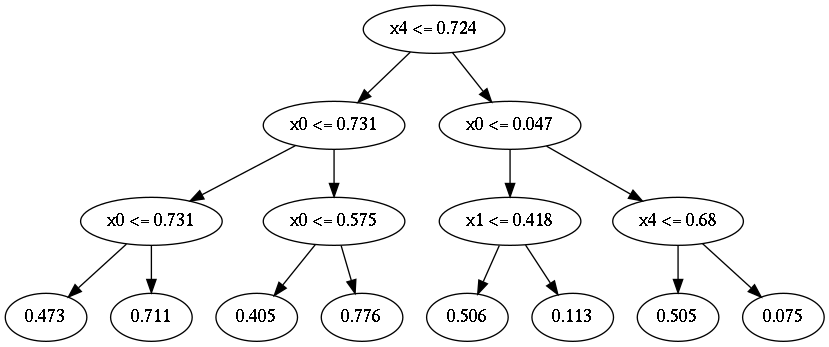

<Figure size 1080x576 with 0 Axes>

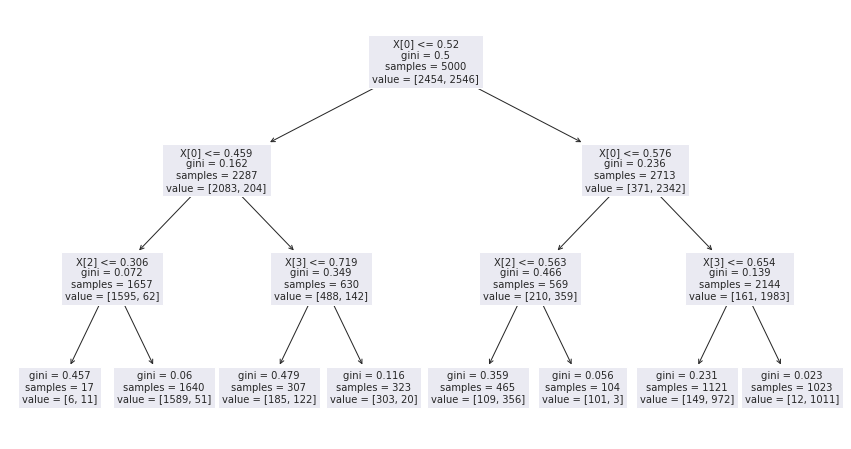

In [10]:
plt.figure(figsize=(15,8))
image = model_dhdt.plot()
display(image)

plt.figure(figsize=(15,8))
plot_tree(model_sklearn, fontsize=10) 
plt.show()

## Cervical Cancer

In [11]:
cc_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00383/risk_factors_cervical_cancer.csv', index_col=False)#, names=feature_names

features_select = [
                    'Age',
                    'Number of sexual partners',
                    'First sexual intercourse',
                    'Num of pregnancies',
                    'Smokes',
                    'Smokes (years)',
                    'Hormonal Contraceptives',
                    'Hormonal Contraceptives (years)',
                    'IUD',
                    'IUD (years)',
                    'STDs',
                    'STDs (number)',
                    'STDs: Number of diagnosis',
                    'STDs: Time since first diagnosis',
                    'STDs: Time since last diagnosis',
                    'Biopsy'
                    ]

cc_data = cc_data[features_select]

cc_data['Number of sexual partners'][cc_data['Number of sexual partners'] == '?'] = cc_data['Number of sexual partners'].mode()[0]
cc_data['First sexual intercourse'][cc_data['First sexual intercourse'] == '?'] = cc_data['First sexual intercourse'].mode()[0]
cc_data['Num of pregnancies'][cc_data['Num of pregnancies'] == '?'] = cc_data['Num of pregnancies'].mode()[0]
cc_data['Smokes'][cc_data['Smokes'] == '?'] = cc_data['Smokes'].mode()[0]
cc_data['Smokes (years)'][cc_data['Smokes (years)'] == '?'] = cc_data['Smokes (years)'].mode()[0]
cc_data['Hormonal Contraceptives'][cc_data['Hormonal Contraceptives'] == '?'] = cc_data['Hormonal Contraceptives'].mode()[0]
cc_data['Hormonal Contraceptives (years)'][cc_data['Hormonal Contraceptives (years)'] == '?'] = cc_data['Hormonal Contraceptives (years)'].mode()[0]
cc_data['IUD'][cc_data['IUD'] == '?'] = cc_data['IUD'].mode()[0]
cc_data['IUD (years)'][cc_data['IUD (years)'] == '?'] = cc_data['IUD (years)'].mode()[0]
cc_data['STDs'][cc_data['STDs'] == '?'] = cc_data['STDs'].mode()[0]
cc_data['STDs (number)'][cc_data['STDs (number)'] == '?'] = cc_data['STDs (number)'].mode()[0]
cc_data['STDs: Time since first diagnosis'][cc_data['STDs: Time since first diagnosis'] == '?'] = cc_data['STDs: Time since first diagnosis'][cc_data['STDs: Time since first diagnosis'] != '?'].mode()[0]
cc_data['STDs: Time since last diagnosis'][cc_data['STDs: Time since last diagnosis'] == '?'] = cc_data['STDs: Time since last diagnosis'][cc_data['STDs: Time since last diagnosis'] != '?'].mode()[0]

nominal_features_cc = [
                        ]
ordinal_features_cc = [
                   ]

    
X_data_cc = cc_data.drop(['Biopsy'], axis = 1)
y_data_cc = pd.Series(OrdinalEncoder().fit_transform(cc_data['Biopsy'].values.reshape(-1, 1)).flatten(), name='Biopsy')


In [12]:
identifier = 'Cervical Cancer'

((X_train_cc, y_train_cc),
 (X_valid_cc, y_valid_cc),
 (X_test_cc, y_test_cc),
 normalizer_list_cc) = preprocess_data(X_data_cc, 
                                           y_data_cc,
                                           nominal_features_cc,
                                           ordinal_features_cc)

Original Data Shape (selected):  (858, 15)
Original Data Shape (encoded):  (858, 15)
Original Data Class Distribution:  55  (true) / 803  (false)
(602, 15) (602,)
(85, 15) (85,)
(171, 15) (171,)
True Ratio:  0.061461794019933555
True Ratio:  0.5


In [13]:
model_sklearn_cc = DecisionTreeClassifier(max_depth=3, random_state=42)

model_sklearn_cc.fit(X_train_cc, y_train_cc)

model_sklearn_cc.score(X_test_cc, y_test_cc)

0.4678362573099415

In [14]:
model_dhdt_cc = DHDT(
            depth=3,
            number_of_variables = X_data_cc.shape[1],
            learning_rate=1e-3,
            squeeze_factor = 1,
            loss='binary_crossentropy',#'binary_crossentropy',
            optimizer='rmsprop',
            random_seed=40,
            verbosity=0)

model_dhdt_cc.fit(X_train_cc, 
               y_train_cc, 
               batch_size=64, 
               epochs=1_000, 
               early_stopping_epochs=50, 
               valid_data=(X_valid_cc, y_valid_cc))

y_test_model_cc = model_dhdt_cc.predict(X_test_cc)
score_dhdt_cc = accuracy_score(y_test_cc, np.round(y_test_model_cc))

print('Test Accuracy', score_dhdt_cc)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test Accuracy 0.17543859649122806


In [15]:
model_dhdt_cc = DHDT(
            depth=3,
            number_of_variables = X_data_cc.shape[1],
            learning_rate=1e-3,
            squeeze_factor = 1,
            loss='binary_crossentropy',#'binary_crossentropy',
            optimizer='adam',
            random_seed=40,
            verbosity=0)

model_dhdt_cc.fit(X_train_cc, 
               y_train_cc, 
               batch_size=64, 
               epochs=1_000, 
               early_stopping_epochs=50, 
               valid_data=(X_valid_cc, y_valid_cc))

y_test_model_cc = model_dhdt_cc.predict(X_test_cc)
score_dhdt_cc = accuracy_score(y_test_cc, np.round(y_test_model_cc))

print('Test Accuracy', score_dhdt_cc)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test Accuracy 0.17543859649122806


In [16]:
model_dhdt_cc = DHDT(
            depth=3,
            number_of_variables = X_data_cc.shape[1],
            learning_rate=1e-3,
            squeeze_factor = 1,
            loss='mae',#'binary_crossentropy',
            optimizer='rmsprop',
            random_seed=40,
            verbosity=0)

model_dhdt_cc.fit(X_train_cc, 
               y_train_cc, 
               batch_size=64, 
               epochs=1_000, 
               early_stopping_epochs=50, 
               valid_data=(X_valid_cc, y_valid_cc))

y_test_model_cc = model_dhdt_cc.predict(X_test_cc)
score_dhdt_cc = accuracy_score(y_test_cc, np.round(y_test_model_cc))

print('Test Accuracy', score_dhdt_cc)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test Accuracy 0.935672514619883


In [17]:
model_dhdt_cc = DHDT(
            depth=3,
            number_of_variables = X_data_cc.shape[1],
            learning_rate=1e-4,
            squeeze_factor = 1,
            loss='binary_crossentropy',#'binary_crossentropy',
            optimizer='rmsprop',
            random_seed=40,
            verbosity=0)

model_dhdt_cc.fit(X_train_cc, 
               y_train_cc, 
               batch_size=64, 
               epochs=1_000, 
               early_stopping_epochs=50, 
               valid_data=(X_valid_cc, y_valid_cc))

y_test_model_cc = model_dhdt_cc.predict(X_test_cc)
score_dhdt_cc = accuracy_score(y_test_cc, np.round(y_test_model_cc))

print('Test Accuracy', score_dhdt_cc)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test Accuracy 0.935672514619883


## Credit Card

In [18]:
credit_card_data = pd.read_csv('./real_world_datasets/UCI_Credit_Card/UCI_Credit_Card.csv', index_col=False) #, delimiter=' '
credit_card_data = credit_card_data.drop(['ID'], axis = 1)
print(credit_card_data.shape)

nominal_features_credit_card = [
                        ]

ordinal_features_credit_card = [
                   ]
    
X_data_credit_card = credit_card_data.drop(['default.payment.next.month'], axis = 1)
y_data_credit_card = ((credit_card_data['default.payment.next.month'] < 1) * 1)



(30000, 24)


In [19]:
identifier = 'Credit Card'

((X_train_credit_card, y_train_credit_card),
 (X_valid_credit_card, y_valid_credit_card),
 (X_test_credit_card, y_test_credit_card),
 normalizer_list_credit_card) = preprocess_data(X_data_credit_card, 
                                           y_data_credit_card,
                                           nominal_features_credit_card,
                                           ordinal_features_credit_card)

Original Data Shape (selected):  (30000, 23)
Original Data Shape (encoded):  (30000, 23)
Original Data Class Distribution:  23364  (true) / 6636  (false)
(21000, 23) (21000,)
(3000, 23) (3000,)
(6000, 23) (6000,)
True Ratio:  0.7782857142857142
True Ratio:  0.5


In [20]:
model_sklearn_credit_card = DecisionTreeClassifier(max_depth=3, random_state=42)

model_sklearn_credit_card.fit(X_train_credit_card, y_train_credit_card)

model_sklearn_credit_card.score(X_test_credit_card, y_test_credit_card)

0.7761666666666667

In [21]:
model_dhdt_credit_card = DHDT(
            depth=3,
            number_of_variables = X_data_credit_card.shape[1],
            learning_rate=1e-3,
            squeeze_factor = 1,
            loss='binary_crossentropy',#'binary_crossentropy',
            optimizer='rmsprop',
            random_seed=40,
            verbosity=0)

model_dhdt_credit_card.fit(X_train_credit_card, 
               y_train_credit_card, 
               batch_size=64, 
               epochs=1_000, 
               early_stopping_epochs=50, 
               valid_data=(X_valid_credit_card, y_valid_credit_card))

y_test_model_credit_card = model_dhdt_credit_card.predict(X_test_credit_card)
score_dhdt_credit_card = accuracy_score(y_test_credit_card, np.round(y_test_model_credit_card))

print('Test Accuracy', score_dhdt_credit_card)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test Accuracy 0.782


In [22]:
model_dhdt_credit_card = DHDT(
            depth=3,
            number_of_variables = X_data_credit_card.shape[1],
            learning_rate=1e-3,
            squeeze_factor = 1,
            loss='binary_crossentropy',#'binary_crossentropy',
            optimizer='adam',
            random_seed=40,
            verbosity=0)

model_dhdt_credit_card.fit(X_train_credit_card, 
               y_train_credit_card, 
               batch_size=64, 
               epochs=1_000, 
               early_stopping_epochs=50, 
               valid_data=(X_valid_credit_card, y_valid_credit_card))

y_test_model_credit_card = model_dhdt_credit_card.predict(X_test_credit_card)
score_dhdt_credit_card = accuracy_score(y_test_credit_card, np.round(y_test_model_credit_card))

print('Test Accuracy', score_dhdt_credit_card)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test Accuracy 0.782


In [23]:
model_dhdt_credit_card = DHDT(
            depth=3,
            number_of_variables = X_data_credit_card.shape[1],
            learning_rate=1e-3,
            squeeze_factor = 1,
            loss='mae',#'binary_crossentropy',
            optimizer='adam',
            random_seed=40,
            verbosity=0)

model_dhdt_credit_card.fit(X_train_credit_card, 
               y_train_credit_card, 
               batch_size=64, 
               epochs=1_000, 
               early_stopping_epochs=50, 
               valid_data=(X_valid_credit_card, y_valid_credit_card))

y_test_model_credit_card = model_dhdt_credit_card.predict(X_test_credit_card)
score_dhdt_credit_card = accuracy_score(y_test_credit_card, np.round(y_test_model_credit_card))

print('Test Accuracy', score_dhdt_credit_card)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test Accuracy 0.782


In [24]:
model_dhdt_credit_card = DHDT(
            depth=3,
            number_of_variables = X_data_credit_card.shape[1],
            learning_rate=1e-4,
            squeeze_factor = 1,
            loss='binary_crossentropy',#'binary_crossentropy',
            optimizer='rmsprop',
            random_seed=40,
            verbosity=0)

model_dhdt_credit_card.fit(X_train_credit_card, 
               y_train_credit_card, 
               batch_size=64, 
               epochs=1_000, 
               early_stopping_epochs=50, 
               valid_data=(X_valid_credit_card, y_valid_credit_card))

y_test_model_credit_card = model_dhdt_credit_card.predict(X_test_credit_card)
score_dhdt_credit_card = accuracy_score(y_test_credit_card, np.round(y_test_model_credit_card))

print('Test Accuracy', score_dhdt_credit_card)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test Accuracy 0.781


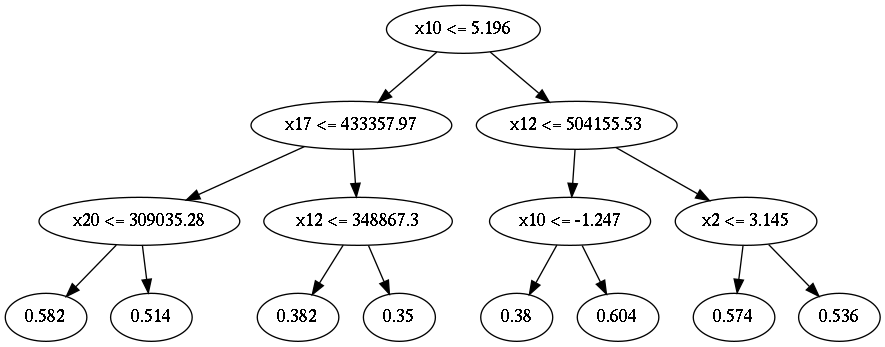

<Figure size 1080x576 with 0 Axes>

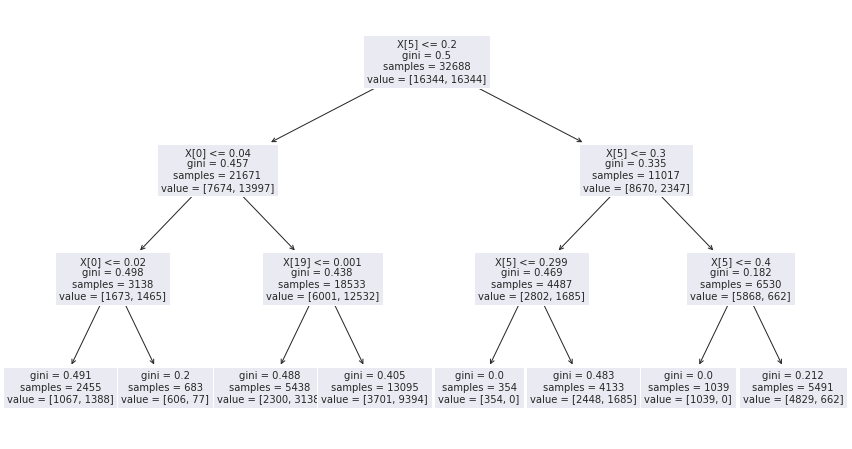

In [25]:
plt.figure(figsize=(15,8))
image = model_dhdt_credit_card.plot(normalizer_list=normalizer_list_credit_card)
display(image)

plt.figure(figsize=(15,8))
plot_tree(model_sklearn_credit_card, fontsize=10) 
plt.show()